### Assignment 6 - Unsupervised Machine Learning Techniques Assignment I


### Author: jd3631 Chloe Du

In this project, I will continue detecting the healthcare fraud. As shown in previous projects, this dataset is pretty clean, so this time what I will focus on, first is to revise the features to make them good enough to fit in the models I will adopt; second is to try two new models (KNNs and PCA) as well as find out the appropriate hyper-parameters to make models perform best; third is to determine a resonable boundary and analyze the summary statistics to identify the abnormal. Finally, I will provide some business insights acquired from the data performance. 

##### info about the data: it is a CSV file, contains 12 features, there is no label to indicate whether the provider is fraud of not

To detect the anomolies, we mainly focus on finding out the unusually high total discharges or cost of treatments to see if there are abuse or wastes. 

#### Review the Healthcare dataset

In [2]:
#import necessary libraries
import numpy as np 
import pandas as pd

from scipy import stats  #for some statistics
from scipy.stats import norm, skew


import matplotlib.pyplot as plt # for visulisation
import seaborn as sns
color = sns.color_palette()
sns.set_style('whitegrid')
%matplotlib inline

import warnings 
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn  #ignore warnings (from sklearn and seaborn)

from plotly.offline import init_notebook_mode, iplot #for ipot visulisation
import plotly.figure_factory as ff
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly
from plotly.subplots import make_subplots
import plotly.express as px

from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True) 

In [3]:
# Now to import and put the dataset 
df = pd.read_csv("/Users/jiayangdu/Desktop/Columbia University /APAN 5420/inpatientCharges.csv")
df.shape
# This original dataset has 163,065 rows and 12 columns

(163065, 12)

In [4]:
#something wrong with the columns, some are not callable, so I just rename them
df.columns= ['DRG Definition','Provider Id','Provider Name','Provider Street Address','Provider City','Provider State','Provider Zip Code','Hospital Referral Region Description','Total Discharges','Average Covered Charges($)','Average Total Payments($)','Average Medicare Payments($)']
# convert datatype
df['Provider Id'] = df['Provider Id'].apply(lambda x:str(x))
df['Provider Zip Code'] = df['Provider Zip Code'].apply(lambda x:str(x))

num_cols = ['Average Covered Charges($)','Average Total Payments($)','Average Medicare Payments($)']
df[num_cols] = df[num_cols].replace({'\$':''}, regex = True)
df['Average Covered Charges($)'] = df['Average Covered Charges($)'].apply(lambda x:float(x))
df['Average Total Payments($)'] = df['Average Total Payments($)'].apply(lambda x:float(x))
df['Average Medicare Payments($)'] = df['Average Medicare Payments($)'].apply(lambda x:float(x))
# since the DRG Definition is too long, to make everything easy, we just extract the code from each DRG Definition 
df['DRG Code'] = df['DRG Definition'].apply(lambda x:x.split('-')[0])

In [5]:
#Take a quick look at some basic categorical data
df.describe(include=['O'])

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,DRG Code
count,163065,163065,163065,163065,163065,163065,163065,163065,163065
unique,100,3337,3201,3326,1977,51,3053,306,100
top,194 - SIMPLE PNEUMONIA & PLEURISY W CC,340141,GOOD SAMARITAN HOSPITAL,100 MEDICAL CENTER DRIVE,CHICAGO,CA,76104,CA - Los Angeles,194
freq,3023,100,633,183,1505,13064,317,3653,3023


In [6]:
df.describe()

,Total Discharges,Average Covered Charges($),Average Total Payments($),Average Medicare Payments($)
count,163065.000000,163065.000000,163065.000000,163065.000000
mean,42.776304,36133.954224,9707.473804,8494.490964
std,51.104042,35065.365931,7664.642598,7309.467261
min,11.000000,2459.400000,2673.000000,1148.900000
25%,17.000000,15947.160000,5234.500000,4192.350000
50%,27.000000,25245.820000,7214.100000,6158.460000
75%,49.000000,43232.590000,11286.400000,10056.880000
max,3383.000000,929118.900000,156158.180000,154620.810000


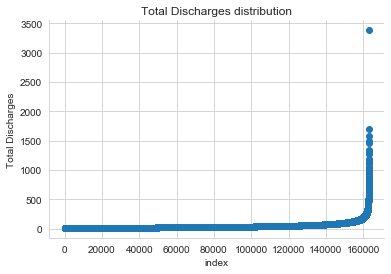

In [7]:
## have a general look at the outliers
plt.scatter(range(df.shape[0]), np.sort(df['Total Discharges'].values))
plt.xlabel('index')
plt.ylabel('Total Discharges')
plt.title("Total Discharges distribution")
sns.despine()

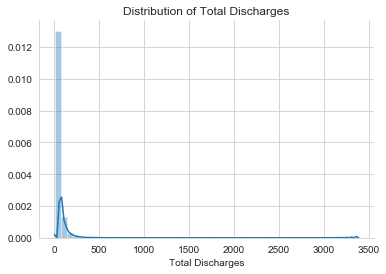

In [8]:
sns.distplot(df['Total Discharges'])
plt.title("Distribution of Total Discharges")
sns.despine()

In [9]:
print("Skewness: %f" % df['Total Discharges'].skew())
print("Kurtosis: %f" % df['Total Discharges'].kurt())

Skewness: 7.667880
Kurtosis: 188.453464


The healthcare’s total discharge distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated on the left of the figure. And the tail total_discharge distribution far exceeds the tails of the normal distribution. There are one region where the data has low probability to appear which is on the right side of the distribution.

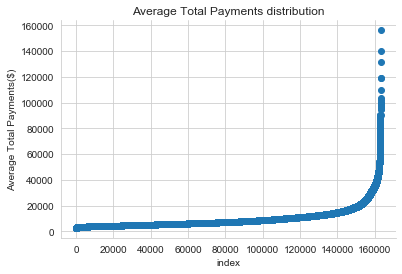

In [10]:
plt.scatter(range(df.shape[0]), np.sort(df['Average Total Payments($)'].values))
plt.xlabel('index')
plt.ylabel('Average Total Payments($)')
plt.title("Average Total Payments distribution")
sns.despine()

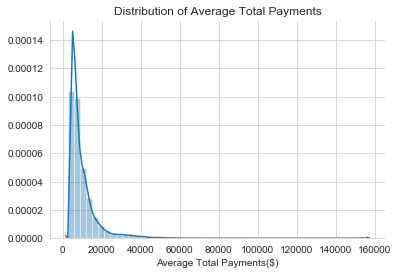

In [11]:
sns.distplot(df['Average Total Payments($)'])
plt.title("Distribution of Average Total Payments")
sns.despine()

In [12]:
print("Skewness: %f" % df['Average Total Payments($)'].skew())
print("Kurtosis: %f" % df['Average Total Payments($)'].kurt())

Skewness: 3.328746
Kurtosis: 17.309320


Average Total Payments($) has the similar distribution with total discharges, positively skewed. 

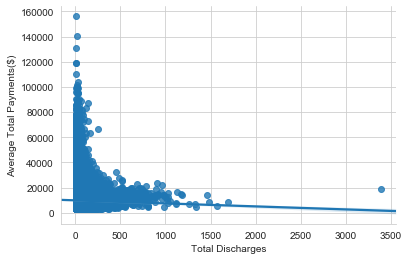

In [13]:
sns.regplot(x="Total Discharges", y='Average Total Payments($)', data=df)
sns.despine();
# we can clearly see there are some outliers 

 From the above correlation chart, we can see that some of the data points are obvious outliers such as extreme low and extreme high values

#### Feature engineering

Here, I will still use the features created last week and add one more benchmark 'median', since mean value is largely influenced by the outliers). here i still group each charges by DRG, State & city respectively

Therefore, the features will include median ratio of mean_ratio_TotalDischarges, mean_ratio_AverageTotalPayments,mean_ratio_AverageMedicarePayments, median_ratio__TotalDischarges, median_ratio__AverageTotalPayments, median_ratio__AverageMedicarePayments, then i will binning these numerical variables.

In [14]:
#benchmark for Average Medicare Payments($) named as 'Mean - Total Discharges'
table1 = df.groupby(['DRG Code','Provider State','Provider City'])['Total Discharges'].apply(lambda x : x.astype(float).mean())
df1 = table1.to_frame()
df1.reset_index(inplace=True)
df1 = df1.rename(columns={'Total Discharges': 'Mean - Total Discharges'})

In [15]:
#benchmark for Average Total Payments($) named as 'Mean - Average Total Payments($)'
table2 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Total Payments($)'].apply(lambda x : x.astype(float).mean())
df2 = table2.to_frame()
df2.reset_index(inplace=True)
df2 = df2.rename(columns={'Average Total Payments($)': 'Mean - Average Total Payments($)'})

In [16]:
#benchmark for Average Medicare Payments($) named as 'Mean - Average Medicare Payments($)'
table3 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Medicare Payments($)'].apply(lambda x : x.astype(float).mean())
df3 = table3.to_frame()
df3.reset_index(inplace=True)
df3 = df3.rename(columns={'Average Medicare Payments($)': 'Mean - Average Medicare Payments($)'})

In [17]:
#benchmark for Average Medicare Payments($) named as 'Mean - Total Discharges'
table4 = df.groupby(['DRG Code','Provider State','Provider City'])['Total Discharges'].apply(lambda x : x.astype(float).median())
df4 = table4.to_frame()
df4.reset_index(inplace=True)
df4 = df4.rename(columns={'Total Discharges': 'Median - Total Discharges'})

In [18]:
#benchmark for Average Total Payments($) named as 'Median - Average Total Payments($)'
table5 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Total Payments($)'].apply(lambda x : x.astype(float).median())
df5 = table5.to_frame()
df5.reset_index(inplace=True)
df5 = df5.rename(columns={'Average Total Payments($)': 'Median - Average Total Payments($)'})

In [19]:
#benchmark for Average Medicare Payments($) named as 'Median - Average Medicare Payments($)'
table6 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Medicare Payments($)'].apply(lambda x : x.astype(float).median())
df6 = table6.to_frame()
df6.reset_index(inplace=True)
df6 = df6.rename(columns={'Average Medicare Payments($)': 'Median - Average Medicare Payments($)'})

In [20]:
# merge benchmarks into the original dataset
df = pd.merge(df, df1, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df2, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df3, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df4, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df5, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df6, on=['DRG Code','Provider State','Provider City'], how='left')

In [21]:
#create new columns to derive the ratios
df['mean_ratio_AverageTotalPayments'] = df['Average Total Payments($)']/df['Mean - Average Total Payments($)']
df['mean_ratio_AverageMedicarePayments'] = df['Average Medicare Payments($)']/df['Mean - Average Medicare Payments($)']
df['mean_ratio_TotalDischarges'] = df['Total Discharges']/df['Mean - Total Discharges']
df['median_ratio__AverageTotalPayments'] = df['Average Total Payments($)']/df['Median - Average Total Payments($)']
df['median_ratio__AverageMedicarePayments'] = df['Average Medicare Payments($)']/df['Median - Average Medicare Payments($)']
df['median_ratio_TotalDischarges'] = df['Total Discharges']/df['Median - Total Discharges']

In [22]:
#extract columns we need for modeling to form a new dataset 'dfm'
columns =['mean_ratio_AverageTotalPayments','mean_ratio_AverageMedicarePayments','mean_ratio_TotalDischarges','median_ratio__AverageTotalPayments','median_ratio__AverageMedicarePayments','median_ratio_TotalDischarges']
dfm = df[columns]

In [23]:
##binning numeric variables
#binning: encoding each numerical features into 10 subgroups (0,10,20,30,40,50,60,70,80,90)
for col in columns:
    dfm[col] = pd.qcut(dfm[col], 10, duplicates='drop', labels=False)

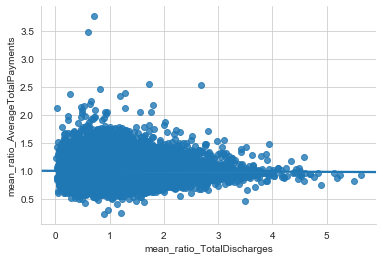

In [24]:
sns.regplot(x="mean_ratio_TotalDischarges", y='mean_ratio_AverageTotalPayments', data=df)
sns.despine();
# we can clearly see there are some outliers 

From the above figure, we can clearly isnpect some points with unusually higher-than-average total payments but unusually lower-than-average total discharges (these points has been grouped by drg and state, so there is no bias caused by different charging standard due to different treatments or region). These points should be mainly focused as outliers. 

#### Model for Anomaly Detection

##### Model 1: KNN

In technical word, KNN is a supervised machine learning algorithm that can be used to solve both classification and regression problems. It works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).The K-Nearest neighbors determines whether or not a point lies in a sparse region of the feature space by computing the sum of the distances to the knearest neighbors of the point. We refer to this quantity as the kNN score for a point. Intuitively, the points in dense regions will have many points near them and will have a small kNN score. If the size of k exceeds the frequency of any given attack type in the data set and the images of the attack elements are far from the images of the normal elements, then the kNN score is useful for detecting these attacks.

KNN is used for not only value predection but also anomaly detection. As k-NN uses underlying patterns in the data to make predictions, any errors in these predictions are thus telltale signs of data points which do not conform to overall trends. In this case, we can examine misclassifications generated from k-NN analysis to identify anomalies. For instance, it seems that healthcare provider is more likely to commit frauds when total discharges or cost of treatment tend to be higher-than-usual.

##### Task 1.
Apply KNN on the dataset, find out the best k using grid search

##### Task 2.
Report the value of performance and give out the business insights

###### For a data point, its distance to its kth nearest neighbor could be viewed as the outlier score.

###### Here, I claim 10% are fraud

##### reference:
https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761 

https://www.listendata.com/2017/12/k-nearest-neighbor-step-by-step-tutorial.html 

https://algobeans.com/2016/09/14/k-nearest-neighbors-anomaly-detection-tutorial/

https://medium.com/analytics-vidhya/introduction-to-anomaly-detection-using-machine-learning-with-a-case-study-part-two-f78243f74d2f

https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

In [25]:
# first to scale the variables 
#StandardSclaer transforms the data to where there is a mean of 0 and a standard deviation of 1
#which means standardizing the data into a normal distribution.
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
dfm = scale.fit_transform(dfm)
dfm = pd.DataFrame(dfm)

In [26]:
# split the data into train test
#from sklearn.model_selection import train_test_split 
#X = dfm
#X_train, X_test = train_test_split(X, test_size = 0.3 , random_state=42 )

In [27]:
# dfm is the dataset used for modelling which only contains important features (refer to last part)
X=dfm
#since there is no label in this dataset, just for the purpose of anomaly detaction, 
#i decide not to split the train test set

In [28]:
# use pyod
# create the KNN model
from pyod.models.knn import KNN 
# train kNN detector
clf_name = 'kNN'
# Initialize detector CLF
clf = KNN(contamination=0.1, n_neighbors = 5,n_jobs=-1) # set 10% as percentage of outliers and try the default k value 5
# Use X_train to train detector CLF
clf.fit(X) 

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)

In [29]:
# Get the prediction labels of the training data 
y_pred = clf.labels_ # binary labels (0: inliers, 1: outliers) 
# Outlier scores 
y_scores = clf.decision_scores_ #(larger scores mean more outliers)

In [30]:
#Using trained CLF to predict outliers in unknown data
#y_test_pred = clf.predict(X_test)  # binary labels (0: inliers, 1: outliers) 
#y_test_scores = clf.decision_function(X_test)  #  Returns outliers on unknown data (larger scores mean more outliers)

In [31]:
#count the number of anomalies
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))
# as shown below, the percentage of anomalies is far smaller than 10%

{0: 161083, 1: 1982}

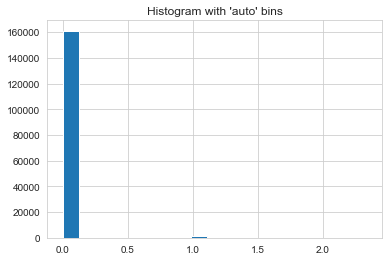

In [33]:
#Determine a reasonable boundary
plt.hist(y_scores, bins='auto')
plt.title("Histogram with 'auto' bins")
plt.show()

In [36]:
#Step 3: Present the summary statistics of the normal and abnormal clusters
# Let's see how many '0's and '1's. We get 161083 '0's and 1982 '1's.
#from the above figure, we set the boundary at 0
dfm['score'] = y_scores
dfm['cluster'] = np.where(dfm['score']>0, 1, 0)
dfm['cluster'].value_counts()
# Now let's show the summary statistics:
dfm.groupby('cluster').mean()

,0,1,2,3,4,5,score
cluster,,,,,,,
0,-0.000424,0.000802,0.000079,-0.008162,-0.007207,-0.007412,0.000000
1,0.034457,-0.065151,-0.006454,0.663364,0.585760,0.602364,1.062786


###### K value
To optimize our model, we need to adjust the parameters.In KNN, the value of k is a key, but finding the value of k is not easy. A small value of k means that noise will have a higher influence on the result and a large value make it computationally expensive.Data scientists usually choose as an odd number if the number of classes is 2.

reference:
https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e

https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb

Since this is unsupervised learning case, no label, so it is hard to select K value by checking a minimum error rate or maximum accuracy. I tried many k values and find out the best outcome when k = sqrt(N) where N stands for the number of samples in your training dataset Therefore, in this case I will ignore set k = sqrt(N). (in the anomaly detection case)

In [39]:
import math 
# Initialize detector CLF
clf2 = KNN(contamination=0.1, n_neighbors = int(math.sqrt(len(X)))) # set 10% as percentage of outliers and try the default k value 5
# Use X_train to train detector CLF
clf2.fit(X) 

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=403, p=2,
  radius=1.0)

In [40]:
# Get the prediction labels of the training data 
y_pred2 = clf2.labels_ # binary labels (0: inliers, 1: outliers) 
# Outlier scores 
y_scores2 = clf2.decision_scores_ #(larger scores mean more outliers)

In [41]:
#count the number of anomalies
unique, counts = np.unique(y_pred2, return_counts=True)
dict(zip(unique, counts))
# the outliers almost accounts for 10%

{0: 148778, 1: 14287}

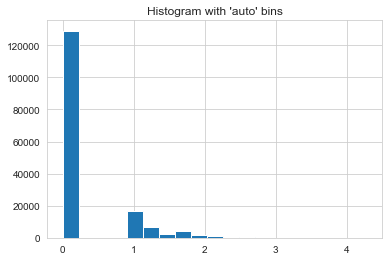

In [46]:
#Determine a reasonable boundary
plt.hist(y_scores2, bins='auto')
plt.title("Histogram with 'auto' bins")
plt.show()

In [123]:
#Step 3: Present the summary statistics of the normal and abnormal clusters
# Let's see how many '0's and '1's. We get 148778 '0's and 14287 '1's.
#from the above figure, we still set the boundary at 0 (larger than 1 is outlier)
dfm['score'] = y_scores2
dfm['cluster'] = np.where(dfm['score']<1, 0, 1)
dfm['cluster'].value_counts()
# Now let's show the summary statistics:
dfm.groupby('cluster').mean()

,0,1,2,3,4,5,score
cluster,,,,,,,
0,0.061245,0.055126,0.004651,-0.048245,-0.052503,-0.090126,0.000000
1,-0.232211,-0.209013,-0.017636,0.182921,0.199068,0.341715,1.322379


The average anomaly score in Cluster 1 is much higher than that of Cluster 0. The summary statistics also show dramatic differences between the two clusters. We thus believe the data points in Cluster 1 could be anomalous and deserve further inspection.

In [43]:
################## try other k values
##try k =50
clf3 = KNN(contamination=0.1, n_neighbors = 50) # set 10% as percentage of outliers and try the default k value 5
# Use X_train to train detector CLF
clf3.fit(X) 

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=50, p=2,
  radius=1.0)

In [44]:
# Get the prediction labels of the training data 
y_pred3 = clf3.labels_ # binary labels (0: inliers, 1: outliers) 
# Outlier scores 
y_scores3 = clf3.decision_scores_ #(larger scores mean more outliers)

In [45]:
unique, counts = np.unique(y_pred3, return_counts=True)
dict(zip(unique, counts))
# no better than the above k = sqrt(n)

{0: 152168, 1: 10897}

In [49]:
##################
##try k =1
clf4 = KNN(contamination=0.1, n_neighbors = 1) # set 10% as percentage of outliers and try the default k value 5
# Use X_train to train detector CLF
clf4.fit(X) 

# Get the prediction labels of the training data 
y_pred4 = clf4.labels_ # binary labels (0: inliers, 1: outliers) 
# Outlier scores 
y_scores4 = clf4.decision_scores_ #(larger scores mean more outliers)

unique, counts = np.unique(y_pred4, return_counts=True)
dict(zip(unique, counts))
# not better 

{0: 162567, 1: 498}

In [124]:
################
#use the outcome produced by k=sqrt(n)
df1 = df.copy()
df1['outlier'] = y_pred2.tolist()

In [125]:
df1.loc[df1['outlier'] == 1].tail(5)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges($),...,Median - Total Discharges,Median - Average Total Payments($),Median - Average Medicare Payments($),mean_ratio_AverageTotalPayments,mean_ratio_AverageMedicarePayments,mean_ratio_TotalDischarges,median_ratio__AverageTotalPayments,median_ratio__AverageMedicarePayments,median_ratio_TotalDischarges,outlier
162995,948 - SIGNS & SYMPTOMS W/O MCC,500139,CAPITAL MEDICAL CENTER,3900 CAPITAL MALL DR SW,OLYMPIA,WA,98502,WA - Olympia,13,18580.92,...,12.5,5163.470,3240.29,0.849353,1.139997,1.040000,0.849353,1.139997,1.040000,1
163017,948 - SIGNS & SYMPTOMS W/O MCC,520004,"MAYO CLINIC HLTH SYSTEM- FRANCISCAN MED CTR, INC",700 WEST AVE S,LA CROSSE,WI,54601,WI - La Crosse,15,14579.06,...,18.5,5263.345,3658.76,0.861543,1.054909,0.810811,0.861543,1.054909,0.810811,1
163038,948 - SIGNS & SYMPTOMS W/O MCC,520087,GUNDERSEN LUTH MED CTR,1910 SOUTH AVE,LA CROSSE,WI,54601,WI - La Crosse,22,16546.36,...,18.5,5263.345,3658.76,1.138457,0.945091,1.189189,1.138457,0.945091,1.189189,1
163049,948 - SIGNS & SYMPTOMS W/O MCC,520136,"WHEATON FRANCISCAN, INC- ST JOSEPH",5000 W CHAMBERS ST,MILWAUKEE,WI,53210,WI - Milwaukee,14,10514.28,...,24.0,5562.500,4269.08,1.017869,1.009557,0.370370,1.000000,1.059427,0.583333,1
163055,948 - SIGNS & SYMPTOMS W/O MCC,520189,AURORA MED CTR KENOSHA,10400 75TH ST,KENOSHA,WI,53142,WI - Milwaukee,28,18099.85,...,52.0,4503.565,3360.72,1.089175,1.012834,0.538462,1.089175,1.012834,0.538462,1


Lets's look in details for a couple of outliers that determined by KNN, and try to understand what make them anomalies.

In [60]:
df.iloc[163049]

DRG Definition                               948 - SIGNS & SYMPTOMS W/O MCC
Provider Id                                                          520136
Provider Name                            WHEATON FRANCISCAN, INC- ST JOSEPH
Provider Street Address                                  5000 W CHAMBERS ST
Provider City                                                     MILWAUKEE
Provider State                                                           WI
Provider Zip Code                                                     53210
Hospital Referral Region Description                         WI - Milwaukee
Total Discharges                                                         14
Average Covered Charges($)                                          10514.3
Average Total Payments($)                                            5562.5
Average Medicare Payments($)                                        4522.78
DRG Code                                                               948 
Mean - Total

For this particular provider, it had a total of 14 discharges with toal payments of $5562.5, but we should notice in MILWAUKEE city in WI state, the cost of treatment for 948 - SIGNS & SYMPTOMS W/O MCC should be cheaper (mean is 5464.85/37.8), so this provider is more likely to commit 'steal a little, all the time'. This provider charges more for 948 treatment.

In [64]:
# to form a datasets containing all outliers to explore more with outliers (remember: in this project i set outliers boundary at 10%)
df_outliers = df1.loc[df1['outlier'] == 1]

In [65]:
df_outliers.describe(include=['O'])

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,DRG Code
count,14287,14287,14287,14287,14287,14287,14287,14287,14287
unique,100,1035,992,1035,329,49,863,230,100
top,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,180088,GOOD SAMARITAN HOSPITAL,200 EAST CHESTNUT STREET,CHICAGO,TX,77030,TX - Houston,470
freq,289,83,102,83,409,1765,166,469,289


From the above statistics, we could get some insights:

a) 470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT is the most common DRG misused by suspicously fraud providers

b) we should inspect provider GOOD SAMARITAN HOSPITAL which often commits fruads.

c) TX state has high fraud rate

###### visulisation

OUTLIERS:  14287 INLIERS:  148778


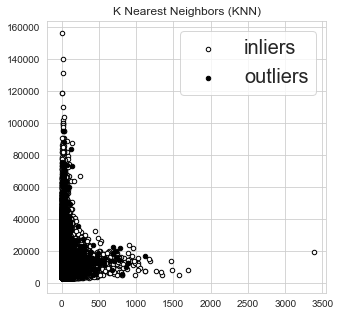

In [137]:
from numpy import percentile
import matplotlib

outliers_fraction=0.1
n_inliers = len(y_pred2) - np.count_nonzero(y_pred2)
n_outliers = np.count_nonzero(y_pred2 == 1)
plt.figure(figsize=(5, 5))
# Total Discharges - inlier feature 1,  Average Total Payments($) - inlier feature 2
inliers_TotalDischarges = df1['Total Discharges'][df1['outlier'] == 0]
inliers_AverageTotalPayments = df1['Average Total Payments($)'][df1['outlier'] == 0]    
# Total Discharges - outlier feature 1, Average Total Payments($) - outlier feature 2
outliers_TotalDischarges = df1['Total Discharges'][df1['outlier'] == 1]
outliers_AverageTotalPayments = df1['Average Total Payments($)'][df1['outlier'] == 1]

print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
b= plt.scatter(inliers_TotalDischarges , inliers_AverageTotalPayments, c='white',s=20, edgecolor='k')
c= plt.scatter(outliers_TotalDischarges, outliers_AverageTotalPayments, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([b,c], ['inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='higher right')         

plt.title('K Nearest Neighbors (KNN)')
plt.show();

##### Model 2: PCA

PCA works by analyzing data that contains multiple variables. It looks for correlations among the variables and determines the combination of values that best captures differences in outcomes. These combined feature values are used to create a more compact feature space called the principal components.

For anomaly detection, each new input is analyzed, and the anomaly detection algorithm computes its projection on the eigenvectors, together with a normalized reconstruction error. The normalized error is used as the anomaly score. The higher the error, the more anomalous the instance is.

###### reference:

https://towardsdatascience.com/fraud-detection-unsupervised-anomaly-detection-df43d81fce67

https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/pca-based-anomaly-detection

In [154]:
# create new dataset for pca model
columns =['mean_ratio_AverageTotalPayments','mean_ratio_AverageMedicarePayments','mean_ratio_TotalDischarges','median_ratio__AverageTotalPayments','median_ratio__AverageMedicarePayments','median_ratio_TotalDischarges']
dfpca = df[columns]

In [155]:
# before setting up the models, we need to define train/test data. (7:3)
from sklearn.model_selection import train_test_split 
dfpca_train, dfpca_test = train_test_split(dfpca, test_size = 0.3 , random_state=42 )

In [156]:
# Normalize data (scale the input variables of the model)
#The “MinMaxScaler” simply re-scales the data to be in the range [0,1]
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(dfpca_train), 
                              columns=dfpca_train.columns, 
                              index=dfpca_train.index)
# Random shuffle training data
X_train.sample(frac=1)
X_test = pd.DataFrame(scaler.transform(dfpca_test), 
                             columns=dfpca_test.columns, 
                             index=dfpca_test.index)

In [160]:
#compress down to two main principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

The Mahalanobis distance metric: In this case, we just want to classify “normal” vs “anomaly”, we use training data that only contains normal operating conditions to calculate the covariance matrix. Then, given a test sample, we compute the Mahalanobis distance to the “normal” class, and classifies the test point as an “anomaly” if the distance is above a certain threshold. (The Mahalanobis distance is a measure of the distance between a point P and a distribution D, measuring how many standard deviations away P is from the mean of D. This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis)

In [167]:
# create a set of functions used in a PCA model:
# Calculate the covariance matrix:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
#Calculate the Mahalanobis distance:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md
#detecting outliers:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)
#Calculate threshold value for classifying datapoint as anomaly:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.    #(defined as 3 standard deviations from the center of the distribution)
    threshold = np.mean(dist) * k
    return threshold
#Check if matrix is positive definite:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [168]:
# PCA model
#Define train/test set from the two main principal components:
dfpca_train = np.array(X_train_PCA.values)
dfpca_test = np.array(X_test_PCA.values)

In [169]:
#Calculate the covariance matrix and its inverse, based on data in the training set:
cov_matrix, inv_cov_matrix  = cov_matrix(dfpca_train)
#calculate the mean value for the input variables in the training set, 
#as this is used later to calculate the Mahalanobis distance to datapoints in the test set
mean_distr = dfpca_train.mean(axis=0)
#Using the covariance matrix and its inverse, we can calculate the Mahalanobis distance for the training data defining “normal conditions”, 
#and find the threshold value to flag datapoints as an anomaly. 
#One can then calculate the Mahalanobis distance for the datapoints in the test set
#and compare that with the anomaly threshold.
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, dfpca_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr,dfpca_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

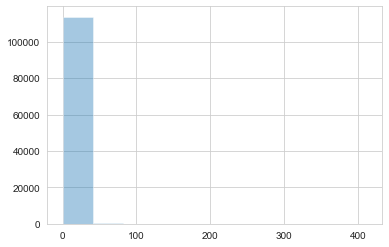

In [175]:
#set threshold value for flagging an anomaly:
#Assumption: The square of the Mahalanobis distance to the centroid of the distribution should follow a χ2 distribution if the assumption of normal distributed input variables is fulfilled.
# visualizing the square of the Mahalanobis distance(which should then ideally follow a χ2 distribution)
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);

Text(0.5, 0, 'Mahalanobis dist')

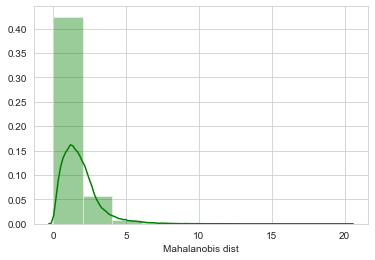

In [176]:
#visualize the Mahalanobis distance
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlabel('Mahalanobis dist')

From the above distributions, the calculated threshold value of 2.25 for flagging an anomaly seems reasonable(defined as 3 standard deviations from the center of the distribution)

In [177]:
# According to Mahalanobis distance and the threshold we set, we could identify outtliers
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
136351,2.334260,2.250858,True
89009,2.539348,2.250858,True
123343,0.032846,2.250858,False
24542,0.660366,2.250858,False
65814,0.453929,2.250858,False


In [178]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])

In [179]:
anomaly_alldata

,Mob dist,Thresh,Anomaly
26935,2.342006,2.250858,True
3332,0.032846,2.250858,False
44167,0.032846,2.250858,False
45554,0.324413,2.250858,False
70056,3.902433,2.250858,True
...,...,...,...
107182,0.227775,2.250858,False
97730,0.553020,2.250858,False
13401,2.047302,2.250858,False
108383,0.032846,2.250858,False


In [210]:
#copy a new clean dataset containing tall of the original feattures
dfpca2=df.drop('outlier',axis=1)

In [211]:
#put the outlier column into he dataset 
dfpca2['outlier'] = anomaly_alldata['Anomaly'].tolist()

In [212]:
# Converting boolean to integer 
dfpca2['outlier']=dfpca2['outlier'].apply(lambda x:np.multiply(x, 1))

In [214]:
# to form a datasets containing all outliers to explore more with outliers (remember: in this project i set outliers boundary at 10%)
dfpca_outliers = dfpca2.loc[dfpca['outlier'] == 1]

Lets's look in details for a couple of outliers that determined by KNN, and try to understand what make them anomalies.

In [221]:
dfpca_outliers.loc[163019]

DRG Definition                           948 - SIGNS & SYMPTOMS W/O MCC
Provider Id                                                      520013
Provider Name                                        SACRED HEART HSPTL
Provider Street Address                            900 W CLAIREMONT AVE
Provider City                                                EAU CLAIRE
Provider State                                                       WI
Provider Zip Code                                                 54701
Hospital Referral Region Description                   MN - Minneapolis
Total Discharges                                                     17
Average Covered Charges($)                                      11501.7
Average Total Payments($)                                       4880.11
Average Medicare Payments($)                                    3268.88
DRG Code                                                           948 
Mean - Total Discharges                                         

For this particular provider, it had a total of 17 discharges with toal payments of $4880.11, but we should notice in EAU CLAIRE City in WI state, the cost of treatment for 948 - SIGNS & SYMPTOMS W/O MCC should be cheaper (mean is 4614.61/21.5), so this provider is suspcious. 

In [215]:
dfpca_outliers.describe(include=['O'])

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,DRG Code
count,18225,18225,18225,18225,18225,18225,18225,18225,18225
unique,100,2982,2860,2972,1834,51,2782,306,100
top,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",260104,GOOD SAMARITAN HOSPITAL,12303 DEPAUL DRIVE,CHICAGO,CA,76104,CA - Los Angeles,392
freq,356,22,74,22,184,1431,38,391,356


From the above statistics produced by PCA, we could get the following insights (we could find we get some same conculusion from KNN):
a) 392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS is often used by suspicious providers
b) GOOD SAMARITAN HOSPITAL should be given more attention, we should take more care of its transactions, since it has been detected as anomoly 
c) CA is a state where providers are more likely to commit frauds.

OUTLIERS:  18225 INLIERS:  144840


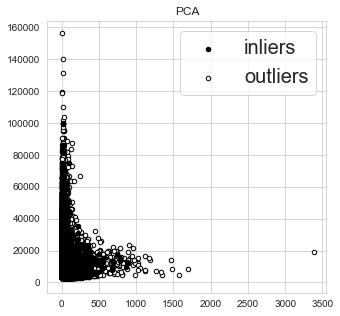

In [217]:
#visulization
from numpy import percentile
import matplotlib

outliers_fraction=0.1
n_inliers = len(dfpca2) - len(dfpca_outliers)
n_outliers = len(dfpca_outliers)
plt.figure(figsize=(5, 5))
# Total Discharges - inlier feature 1,  Average Total Payments($) - inlier feature 2
inliers_TotalDischarges = dfpca2['Total Discharges'][dfpca2['outlier'] == 0]
inliers_AverageTotalPayments = dfpca2['Average Total Payments($)'][dfpca2['outlier'] == 0]    
# Total Discharges - outlier feature 1, Average Total Payments($) - outlier feature 2
outliers_TotalDischarges = dfpca2['Total Discharges'][dfpca2['outlier'] == 1]
outliers_AverageTotalPayments = dfpca2['Average Total Payments($)'][dfpca2['outlier'] == 1]

print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
b= plt.scatter(inliers_TotalDischarges , inliers_AverageTotalPayments, c='white',s=20, edgecolor='k')
c= plt.scatter(outliers_TotalDischarges, outliers_AverageTotalPayments, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([c,b], ['inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='higher right')         

plt.title('PCA')
plt.show();